In [2]:
schema = 'ds_data_for_complexity'

In [3]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
from scipy import stats
from keplergl import KeplerGl

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter

import geohash2
import json

In [4]:
# SQL engine
from trino.dbapi import connect 
from sqlalchemy import create_engine

class TrinoEngine():
    def __init__(self):
        conn = connect(
            host="localhost",
            port=9090,
            catalog="cuebiq"
        )
        self.cur = conn.cursor()
        self.engine = create_engine("trino://localhost:9090/cuebiq/")
    
    def execute_statement(self, query:str) -> list:
        """
        Create and drop statements.
        """
        self.cur.execute(query)
        return self.cur.fetchall()
    
    def read_sql(self, query:str) -> pd.DataFrame: 
        """
        Select and insert into operations.
        """
        return pd.read_sql(query, self.engine)

sql_engine = TrinoEngine()

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [6]:
folder_name = f'dedicated.{schema}'
stops_table_name = f'dedicated.{schema}.selected_stops_limited'
device_location_table_name = f'dedicated.{schema}.device_location_and_stops_subsampled'
dev_loc_model = f'dedicated.{schema}.device_location_and_stops_forreal_forreal'

## Analyze features

In [7]:
# columns
query = f"""
    SELECT *
    FROM {dev_loc_model}
    limit 10
"""
result = sql_engine.read_sql(query)
result.columns

Index(['data_provider', 'id_type', 'lineage_id', 'event_timestamp',
       'event_zoned_datetime', 'lat', 'lng', 'geohash', 'accuracy',
       'classification_type', 'stop_id', 'stop_class', 'geohash_level_8',
       'day_period_code', 'dayofweek', 'geo_dens_collective_hourly',
       'geo_dens_individual_hourly', 'geo_dens_collective_weekly',
       'geo_dens_individual_weekly', 'geohash_entropy',
       'num_of_individual_stops_last_hour', 'num_of_individual_stops_last_day',
       'num_of_individual_stops_last_week',
       'num_of_collective_stops_last_hour', 'num_of_collective_stops_last_day',
       'num_of_collective_stops_last_week', 'space', 'time', 'prev_accuracy',
       'next_accuracy', 'prev_prev_accuracy', 'next_next_accuracy',
       'subsampled', 'event_date'],
      dtype='object')

In [8]:
columns_to_correlate = ['time',
        'space',
        'num_of_individual_stops_last_hour',
        'num_of_collective_stops_last_hour',
        'num_of_individual_stops_last_day',
        'num_of_collective_stops_last_day',
        'num_of_individual_stops_last_week',
        'num_of_collective_stops_last_week',
        'geo_dens_individual_hourly',
        'geo_dens_collective_hourly',
        'geo_dens_individual_weekly',
        'geo_dens_collective_weekly',
        'geohash_entropy',
        'prev_accuracy',
        'accuracy',
        'next_accuracy']
#columns_to_correlate = ['is_stop','geohash_entropy']

def query_corr(query):
    retries = 0
    while retries < 5:
        try:
            corr = sql_engine.read_sql(query)['correlation'][0]
            return corr
        except Exception as e:
            print(f"Error saving chunk (attempt {retries + 1}): {e}")
            retries = retries + 1
            time.sleep(1)
    print("Error: too many retries")
        
correlations = {}
k = 0
for i,col1 in enumerate(columns_to_correlate):
    for j,col2 in enumerate(columns_to_correlate):
        if i < j:  # Avoid self-correlation
            query = f"""
                WITH dev_loc_columns AS(
                    SELECT *,
                        CASE
                            WHEN stop_class IS NULL THEN 0
                            ELSE 1
                        END AS is_stop

                    FROM {dev_loc_model}
                )
                SELECT corr({col1}, {col2}) AS correlation
                FROM dev_loc_columns
                """
            correlations[(col1, col2)] = query_corr(query)
            correlations[(col2, col1)] = correlations[(col1, col2)]
            k += 1
            n_cols = len(columns_to_correlate)
            print(f"{k} out of {(n_cols-1)*(n_cols)/2}: {col1},{col2} done.", end="\r", flush=True)



In [27]:
correlation_matrix = pd.DataFrame(index=columns_to_correlate, columns=columns_to_correlate)

for i,col1 in enumerate(columns_to_correlate):
    for j,col2 in enumerate(columns_to_correlate):
        if col1 == col2:
            correlation_matrix.loc[col1, col2] = 1.0  # Self-correlation is 1
        else:
            if i > j:
                correlation_matrix.loc[col1, col2] = correlations[(col1, col2)]
                correlation_matrix.loc[col2, col1] = correlations[(col1, col2)]  # Make it symmetric
correlation_matrix = correlation_matrix.fillna(0)
correlation_matrix

,time,space,num_of_individual_stops_last_hour,num_of_collective_stops_last_hour,num_of_individual_stops_last_day,num_of_collective_stops_last_day,num_of_individual_stops_last_week,num_of_collective_stops_last_week,geo_dens_collective_hourly,geo_dens_individual_hourly,geo_dens_collective_weekly,geo_dens_individual_weekly,geohash_entropy,prev_accuracy,accuracy,next_accuracy
time,1.000000,0.232206,0.015717,0.016057,0.027964,0.027899,0.039247,0.039139,-0.003563,-0.019104,-0.015031,-0.029802,-0.034169,0.018015,0.054872,0.055263
space,0.232206,1.000000,-0.006456,-0.005744,-0.008587,-0.007689,-0.005865,-0.004445,-0.014511,-0.015630,-0.020365,-0.020704,0.019167,0.038017,0.033755,0.045190
num_of_individual_stops_last_hour,0.015717,-0.006456,1.000000,0.945484,0.515444,0.491171,0.273829,0.267530,0.123214,0.093001,0.135651,0.111281,-0.017337,0.018052,0.014975,0.021722
num_of_collective_stops_last_hour,0.016057,-0.005744,0.945484,1.000000,0.487685,0.505521,0.258502,0.256727,0.116692,0.086800,0.125398,0.101614,-0.009104,0.017733,0.013705,0.021303
num_of_individual_stops_last_day,0.027964,-0.008587,0.515444,0.487685,1.000000,0.961439,0.612412,0.590699,0.316339,0.293483,0.447115,0.433899,-0.091511,0.021623,0.017162,0.023479
num_of_collective_stops_last_day,0.027899,-0.007689,0.491171,0.505521,0.961439,1.000000,0.590459,0.584412,0.308989,0.284544,0.433551,0.418458,-0.065251,0.021772,0.016538,0.023537
num_of_individual_stops_last_week,0.039247,-0.005865,0.273829,0.258502,0.612412,0.590459,1.000000,0.963173,0.603011,0.596414,0.669112,0.666629,-0.132607,0.024344,0.018394,0.025626
num_of_collective_stops_last_week,0.039139,-0.004445,0.267530,0.256727,0.590699,0.584412,0.963173,1.000000,0.591496,0.575582,0.655169,0.642878,-0.067587,0.025805,0.019371,0.027062
geo_dens_collective_hourly,-0.003563,-0.014511,0.123214,0.116692,0.316339,0.308989,0.603011,0.591496,1.000000,0.989797,0.701895,0.691572,-0.104974,0.009355,0.003460,0.012475
geo_dens_individual_hourly,-0.019104,-0.015630,0.093001,0.086800,0.293483,0.284544,0.596414,0.575582,0.989797,1.000000,0.697113,0.701402,-0.120638,0.018441,-0.008702,0.008421


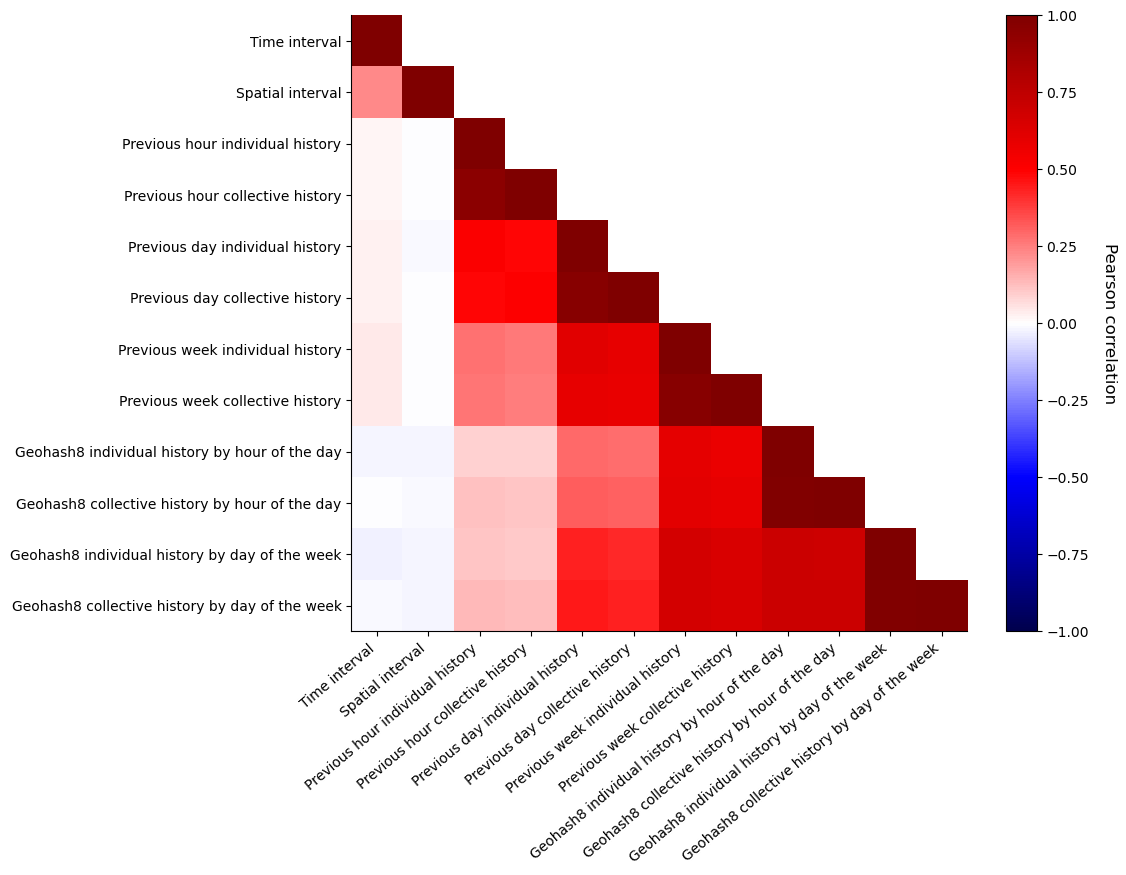

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm

# Sample correlation matrix (replace with your actual data)
data = {'A': [1, 0.8, 0.2],
        'B': [0.8, 1, -0.5],
        'C': [0.2, -0.5, 1]}

df = correlation_matrix#.drop(index='is_stop', columns='is_stop')

new_order = ['time',
        'space',
        'num_of_individual_stops_last_hour',
        'num_of_collective_stops_last_hour',
        'num_of_individual_stops_last_day',
        'num_of_collective_stops_last_day',
        'num_of_individual_stops_last_week',
        'num_of_collective_stops_last_week',
        'geo_dens_individual_hourly',
        'geo_dens_collective_hourly',
        'geo_dens_individual_weekly',
        'geo_dens_collective_weekly']

names = {'time':'Time interval',
        'space':'Spatial interval',
        'num_of_individual_stops_last_hour':'Previous hour individual history',
        'num_of_collective_stops_last_hour':'Previous hour collective history',
        'num_of_individual_stops_last_day':'Previous day individual history',
        'num_of_collective_stops_last_day':'Previous day collective history',
        'num_of_individual_stops_last_week':'Previous week individual history',
        'num_of_collective_stops_last_week':'Previous week collective history',
        'geo_dens_individual_hourly':'Geohash8 individual history by hour of the day',
        'geo_dens_collective_hourly':'Geohash8 collective history by hour of the day',
        'geo_dens_individual_weekly':'Geohash8 individual history by day of the week',
        'geo_dens_collective_weekly':'Geohash8 collective history by day of the week',
        'geohash_entropy':'Geohash8 entropy',
        'prev_accuracy':'Previous point accuracy',
        'accuracy':'Accuracy',
        'next_accuracy':'Next point accuracy'}

df = df.reindex(index=new_order, columns=new_order)

for i,col1 in enumerate(df.index):
    for j,col2 in enumerate(df.columns):
        if i > j:
            df.loc[col2, col1] = pd.NA


df = df.rename(columns=names)
# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size as needed
im = ax.matshow(df, cmap='seismic', norm=CenteredNorm(0))  # 'coolwarm' for diverging colormap
#sns.heatmap(df, cmap="seismic", annot=True, fmt=".2f", ax=ax, norm=CenteredNorm(0))
# Customize the plot

ax.set_xticks(np.arange(len(df.columns)))
ax.set_yticks(np.arange(len(df.columns)))
ax.set_xticklabels(df.columns, rotation=40, ha="right")
ax.set_yticklabels(df.columns)
ax.xaxis.set_ticks_position('bottom')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


"""
# Add correlation values as text annotations
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        ax.text(j, i, round(df.iloc[i, j], 2),
                ha="center", va="center", color="black")
"""


# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax, )
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Pearson correlation', rotation=270, labelpad=20, size=12)  # Adjust rotation and padding as needed


#plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.show()
